In [1]:
import numpy as np
import scipy.io

# random seed.
rand_seed = 2

from numpy.random import seed
seed(rand_seed)
from tqdm.keras import TqdmCallback
import tensorflow
tensorflow.random.set_seed(rand_seed)

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Activation
from keras.layers.core import Permute, Reshape
from keras import backend as K

In [2]:
def one_hot_encoding(y_data):
    Mapping=dict()
    sub_dirs=['downstair','upstair','run','jump','walk','handwashing','exercise']

    categories=10
    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        lab=Mapping[Type]
        y_features2.append(lab)

    y_features=np.array(y_features2)
    y_features=y_features.reshape(y_features.shape[0],1)
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)

    return y_features

In [3]:
path='C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/data/'

def get_train_and_validate_data(path=path):
    Train_data=np.load(path+'Data_train_all.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']

    Labels = one_hot_encoding(Labels)
    
    randomize = np.arange(len(Labels))
    np.random.shuffle(randomize)
    
    Labels = Labels[randomize]
    Features_imu = Features_imu[randomize]
    
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2])
    
    new_Labels = np.split(Labels,[Labels.shape[0] - 2000])
    Features_imu = np.split(Features_imu,[Features_imu.shape[0] - 2000])

    return new_Labels[0],Features_imu[0].astype(np.float64),new_Labels[1],Features_imu[1].astype(np.float64)

def get_test_data(path=path):
    Train_data=np.load(path+'Data_test_71.pkl',allow_pickle=True)
    Features_imu=Train_data[0]
    Labels=Train_data[1]

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Labels,Features_imu.astype(np.float64)

In [4]:
Labels,Features_imu,Labels2,Features_imu2 = get_train_and_validate_data()
print(Labels.shape,Features_imu.shape)
print('Train Classes distribution: ',np.sum(Labels, axis = 0))

print(Labels2.shape,Features_imu2.shape)
print('Validate Classes distribution: ',np.sum(Labels2, axis = 0))

Labels3,Features_imu3 = get_test_data()
print(Labels3.shape,Features_imu3.shape)
print('Test Classes distribution: ',np.sum(Labels3, axis = 0))

(9976, 7) (9976, 1, 40, 12)
Train Classes distribution:  [1539. 1971. 1089. 1510. 1044. 1489. 1334.]
(2000, 7) (2000, 1, 40, 12)
Validate Classes distribution:  [294. 389. 219. 338. 228. 290. 242.]
(1377, 7) (1377, 1, 40, 12)
Test Classes distribution:  [219. 268. 124. 146. 143. 234. 243.]


# IMU Model

In [5]:
# With dropout in the network

num_feat_map = 32

_, dim, win_len, _, = Features_imu.shape
num_classes=7


def full_imu_model():  
    print('building the model ... ')        
    model = Sequential()
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                  input_shape=(dim, win_len, 12),
                 padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Flatten())
    model.add(Dense(256, name='DENSE_3'))
    model.add(Activation('relu', name = 'ACT_3'))
    model.add(Dropout(0.3))
    model.add(Dense(128, name='DENSE_2'))
    model.add(Activation('relu', name = 'ACT_2'))
    model.add(Dense(64, name='DENSE_1'))
    model.add(Activation('relu', name = 'ACT_1'))

    model.add(Dense(num_classes, activation='softmax', name = 'OUTPUT'))
    
    return model

In [6]:
IMU_model = full_imu_model()

building the model ... 


In [7]:
IMU_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 40, 32)         1952      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 20, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 20, 32)         5152      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 10, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
DENSE_3 (Dense)              (None, 256)               82176     
_________________________________________________________________
ACT_3 (Activation)           (None, 256)               0

In [8]:
model_path = 'C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models/imu_model_checkpoint'


from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_accuracy' ,save_best_only=True, save_weights_only=False)
earlystopper = EarlyStopping(monitor='val_accuracy',patience=5)

In [9]:
batch_size = 128
epochs = 50
from keras import optimizers
from keras.optimizers import Adam

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
IMU_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= adam,
              metrics=['accuracy'])

import time
start_time = time.time()

learning_hist = IMU_model.fit(Features_imu, Labels,
                    verbose=0,
                    epochs=epochs,
                    shuffle=True,
                    batch_size=batch_size,
                    callbacks=[checkpointer,earlystopper,TqdmCallback(verbose=2)],
                    validation_data=(Features_imu2, Labels2))

end_time = time.time()

print("---Time %s seconds ---" % (end_time - start_time))

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00001: val_accuracy improved from -inf to 0.51000, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00002: val_accuracy improved from 0.51000 to 0.73500, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00003: val_accuracy improved from 0.73500 to 0.81800, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00004: val_accuracy improved from 0.81800 to 0.87950, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00005: val_accuracy improved from 0.87950 to 0.90150, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00006: val_accuracy improved from 0.90150 to 0.91050, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00007: val_accuracy improved from 0.91050 to 0.91750, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00008: val_accuracy did not improve from 0.91750


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00009: val_accuracy improved from 0.91750 to 0.92200, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00010: val_accuracy improved from 0.92200 to 0.93150, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00011: val_accuracy improved from 0.93150 to 0.93350, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00012: val_accuracy improved from 0.93350 to 0.93650, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00013: val_accuracy did not improve from 0.93650


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00014: val_accuracy did not improve from 0.93650


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00015: val_accuracy improved from 0.93650 to 0.94350, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00016: val_accuracy improved from 0.94350 to 0.94550, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00017: val_accuracy did not improve from 0.94550


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00018: val_accuracy did not improve from 0.94550


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00019: val_accuracy improved from 0.94550 to 0.94650, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00020: val_accuracy did not improve from 0.94650


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00021: val_accuracy improved from 0.94650 to 0.94800, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00022: val_accuracy did not improve from 0.94800


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00023: val_accuracy improved from 0.94800 to 0.95100, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00024: val_accuracy did not improve from 0.95100


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00025: val_accuracy did not improve from 0.95100


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00026: val_accuracy did not improve from 0.95100


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00027: val_accuracy did not improve from 0.95100


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00028: val_accuracy did not improve from 0.95100
---Time 27.04721212387085 seconds ---


In [10]:
from keras.models import load_model

IMU_model = load_model(model_path)

In [11]:
#Train Accuracy
IMU_model.evaluate(Features_imu,Labels)

312/312 [==============================] - 1s 2ms/step - loss: 0.0174 - accuracy: 0.9936


[0.01737186126410961, 0.9935845732688904]

In [12]:
#valid Accuracy
IMU_model.evaluate(Features_imu2,Labels2)

63/63 [==============================] - 0s 2ms/step - loss: 0.2102 - accuracy: 0.9510


[0.21016189455986023, 0.9509999752044678]

In [13]:
#Test Accuracy
IMU_model.evaluate(Features_imu3,Labels3)

44/44 [==============================] - 0s 2ms/step - loss: 0.4108 - accuracy: 0.9165


[0.41080087423324585, 0.9164851307868958]

# Plotting

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


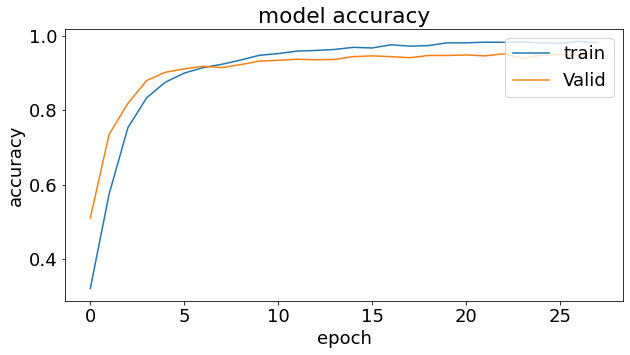

In [14]:
from matplotlib import pyplot as plt

print(learning_hist.history.keys())
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

plt.plot(learning_hist.history['accuracy'])
plt.plot(learning_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()

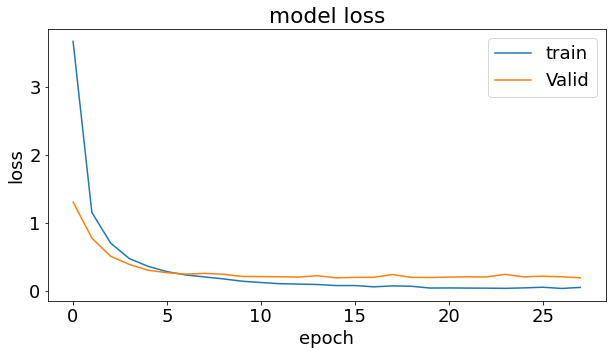

In [15]:
# summarize history for loss

from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})


plt.plot(learning_hist.history['loss'])
plt.plot(learning_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()

In [16]:
K.clear_session()